# Simulation of a semi-resolved dwarf galaxy

The purpose of this notebook is to sketch out the steps in simulating a semi-resolved dwarf galaxy. The steps are as follows:

 1. Select an isochrone
     - which gives the colors and luminosities of stars as a function of mass for a particular fixed age and metallicity
     - ideally someone has already done the work to compute the colors for the telescope and filter of interest
     - There are some nifty isochrones at http://waps.cfa.harvard.edu/MIST/
 1. Select a total mass for the dwarf galaxy
     - ultimately, at random from a galaxy stellar-mass function (Schechter)
 1. Draw star masses at random from an initial mass function 
     - There is a package for this https://github.com/keflavich/imf. One could also do this with Astropy models no doubt, but that would require more thought.
     - need to decide on a lower mass limit for this so we don't spend all our time on stars that don't contribute to fluctuations. Add those in as one additional smooth component, with the right total flux relative to the stars we have added individually.
         - simplest shortcut to this is probably to include stars only above the Main-sequence turnoff (in phase >0) in the stochastic component. But for younger populations, we might need to keep Main-sequence stars, so let's make this 1 solar mass or the MSTO, whichever is smaller.  
     - draw enough stars that the total mass of the smooth + individual components adds up to the total mass you want for the dwarf galaxy.
     - $N_{indiv}$ is the total number of individual stars
 1. Create a star catalog by assigning the colors and luminosities to the stars according to the isochrone
 1. Choose a distance (or equivalently distance modulus $DM = -5 * log10(distance Mpc) + 25$
 1. Convert luminosities to apparent magnitudes using this distance
 1. Choose a 2D model profile for the galaxy
     - Typically, these galaxies have Sersic profiles with n ~ 1, half-light radii of ~ 0.5-1 kpc and axial ratios between 0.5 and 1
     - We will ultimately want to draw these from distribution functions (there are some in the literature)
     - This should be oversampled by at least a factor of 4 relative to the pixel sampling of the telescope/survey of choice (e.g. WFIRST, LSST or HSC).  
 1. Make an image from the profile where the value in each pixel is the stellar mass, and the total sums to the desired stellar mass
 1. For each pixel draw the right number of stars at random from the isochrone
     - The mass in the pixel $M_{pix}$ is given from the smooth image we just made
     - The number of stars $N_{pix}$ to draw for this pixel is then $N_{indiv} * M_{pix}/M_{tot}$
     - Draw $N_{pix}$ stars at random from the star catalog and increment the flux in this (over-resolved) pixel by this amount
 1. Add in the flux for the smooth component (which is just the model profile scaled by the mass fraction and multipled by a normalization to get it from mass to luminosity)
 1. Convolve this image with an oversampled PSF from the survey of choice 
 1. Resample to the pixelization of the survey
 1. Either add to a real survey image or add sky background and artificial noise
    - Quick & dirty is to ignore Poisson noise from the stars and either just add the noiseless image to the survey data, or measure the RMS in blank sky in the survey and use that to set the rms and mean level for the sky background
    - Ultimately there are correlations introduced by dithering that we probably need to take into account or simulate
    - There is also Poisson noise (photon counting statistics) for the galaxy we just simulated but that's sub-dominant relative to sky: the central surface brightnesses of these galaxies are typically well below the mean sky level.
 

In [1]:
import imf # https://github.com/keflavich/imf
from astropy.table import Table
from scipy import interpolate
import numpy as np
from astropy import modeling
from astropy.cosmology import Planck15 as cosmo
from scipy import stats
from astropy.io import fits
from astropy.convolution import convolve_fft
from scipy import integrate

In [2]:
# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

Set the zeropoint and pixel scale

In [3]:
arcsec_per_pixel = 0.168/4. # 4 times oversampled when making the image before convolving
bands = ['g','r','i','z','y']
# Zeropoint is the same for all the bands for HSC data
zpt = {}
for b in bands:
    zpt[b] = 27.0

Read in the isochrone, select a single age, and create a column that is flux in counts/sec in the desired band for each stellar mass bin

In [4]:
isochrone=Table.read('MIST_v1.2_vvcrit0.4_HSC/MIST_v1.2_feh_m0.50_afe_p0.0_vvcrit0.4_HSC.iso.cmd',
                     format='ascii.commented_header',header_start=-1)
# Convert to flux at 10pc
isochrone = isochrone[isochrone['log10_isochrone_age_yr'] == 10] # Select a single age
for b in bands:
    isochrone[b+'flux'] = 10**(isochrone['hsc_'+b]/-2.5)
isochrone[:5]

EEP,log10_isochrone_age_yr,initial_mass,star_mass,log_Teff,log_g,log_L,[Fe/H]_init,[Fe/H],hsc_g,hsc_r,hsc_i,hsc_z,hsc_y,hsc_nb816,hsc_nb921,phase,gflux,rflux,iflux,zflux,yflux
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
243,10.0,0.1,0.09999923186725665,3.500710470387624,5.292183509118035,-2.8965530503433956,-0.5,-0.471093,15.093611,13.557161,12.16713,11.728948,11.416001,11.858782,11.480196,0.0,9.173933759949728e-07,3.7769009890023025e-06,1.3587764150479422e-05,2.0343271724761495e-05,2.713935988013017e-05
244,10.0,0.10062393184158601,0.10062315407651276,3.5011987091548686,5.290511699719402,-2.8907309268035455,-0.5,-0.471075,15.066809,13.532233,12.149733,11.713964,11.401618,11.843019,11.465957,0.0,9.403215732757791e-07,3.864620025932478e-06,1.3807237650436773e-05,2.06259708670916e-05,2.7501273174055957e-05
245,10.0,0.1050473878918744,0.1050465392201687,3.5046614173007393,5.278656010990385,-2.849445911398444,-0.5,-0.470949,14.878497,13.357088,12.026728,11.607905,11.299599,11.731381,11.364938,0.0,1.11841040801775e-06,4.541139047569697e-06,1.5463535653061302e-05,2.274248934954816e-05,3.0210672992086867e-05
246,10.0,0.10929530137475559,0.10929437997218518,3.507988997235598,5.26726473174833,-2.8097840505054577,-0.5,-0.470819,14.700777,13.191797,11.909272,11.506346,11.201671,11.624409,11.267858,0.0,1.3173136742492682e-06,5.287875239643749e-06,1.7230234970211537e-05,2.4972475745906663e-05,3.306218868021379e-05
247,10.0,0.11404757388077219,0.11404656544515104,3.5117148519142227,5.254509980716523,-2.7653893815963695,-0.5,-0.470664,14.505976,13.010756,11.778766,11.393139,11.092256,11.504999,11.159198,0.0,1.5761937460529015e-06,6.247375354648068e-06,1.943093057139951e-05,2.7716883729754936e-05,3.6567696180617045e-05


So we don't spend all our time drawing stars that are too faint to contribute significant fluctuations, set a minimum stellar mass for the stochastic component that is either 1 solar mass or the main-sequence turnoff, whichever is smaller. In young stellar populations, the main-sequence stars could be bright & rare enough to contribute fluctuations. In older populations it will be dominated by post-MS stars. 

In [5]:
minmass_stochastic = min(1.0,isochrone['initial_mass'][isochrone['phase']<0.1][-1])
minmass_stochastic

0.9027923627682554

Compute the fraction of the total mass in the stochastic component (the rest will be in the smooth component)

In [6]:
kroupa = imf.Kroupa(mmin=0.1, mmax=120, p1=0.3, p2=1.3, p3=2.3,
                 break1=0.08, break2=0.5)
kroupa.normalize()
mmax = 200
stochastic_mass_fraction = (kroupa.m_integrate(minmass_stochastic, mmax)[0] /
                 kroupa.m_integrate(kroupa.mmin, mmax)[0])
stochastic_mass_fraction

0.5977522091206898

Compute the total light flux at 10pc in the smooth component in each band per unit mass at 10 pc
 - compute the mass bins $dm$ for the isochrone
 - weight the light by $dm * (dN/dm)$ where $dN/dm$ comes from the call to the imf (which is normalized to a total mass of 1 over the mass range specified)

In [7]:
m = isochrone['initial_mass']
dn_dm = kroupa(m)
smooth_flux = {}
selection = isochrone['initial_mass'] <= minmass_stochastic
for b in bands:
    smooth_flux[b] = integrate.simps(m[selection],isochrone[b+'flux'][selection]*dn_dm[selection])
smooth_flux

{'g': 0.003899834408401458,
 'r': 0.005082925387158677,
 'i': 0.005408585568378817,
 'z': 0.004727913096495838,
 'y': 0.0052956841022830945}

Make a smooth model galaxy with a Sersic profile

In [8]:
class GalaxyModel:
    def __init__(self,massrange=(1.e5,1.e8),distrange=(2.,10.),npix=512):
        # Replace these with draws from distribution functions
        self.npix=npix
        self.total_mass = 1.e7
        self.re_kpc = 0.25 # Kpc
        self.sersic_index = 1.0
        self.axial_ratio = 0.5
        self.ellip = 1.-self.axial_ratio
        self.position_angle = 45.*np.pi/180. # radians
        # Choose the distance (replace this with a draw)
        self.redshift = 0.001 # ignoring peculiar velocities
        self.lumdist = cosmo.luminosity_distance(self.redshift).value
        self.re_arcsec = self.re_kpc*cosmo.arcsec_per_kpc_proper(self.redshift)
        self.re_pixels = self.re_arcsec.value/arcsec_per_pixel
        self.create_model(npix=npix)
        
    def create_model(self,npix=512):
        N=npix
        x,y = np.meshgrid(np.arange(N),np.arange(N))
        self.x = x
        self.y = y
        self.model = modeling.models.Sersic2D(
            amplitude=1,
            r_eff=self.re_pixels,
            n=self.sersic_index,
            x_0=N/2,y_0=N/2,
            ellip=self.ellip,theta=self.position_angle)
        self.normalization = np.sum(self.model(x,y).flat)
        self.model_image = self.model(x,y)/self.normalization
        self.mass_model = self.model_image*self.total_mass
        
    def create_poisson_model(self,nstars):
        # N stars is the total number of stars in the stochastic component
        # The model tells how many on average there are per pixel
        # And then we do a poisson draw on that number
        mu = nstars*self.model_image
        self.poisson_model = stats.poisson.rvs(mu,size=self.model_image.shape) 

In [9]:
Npix = 1024
galaxy = GalaxyModel(npix=Npix)
galaxy.lumdist

4.4290328647590735

Convert Fluxes into counts/second given the distance and photometric zeropoint

In [10]:
def observed_cts_per_sec(isochrone_flux,lumdist,zpt=27.0):
    zptflux = 10.**(zpt/2.5)
    distratio = galaxy.lumdist *1.e6/10.  # lumdist is in Mpc, isochrone is computed for 10 parsecs
    return isochrone_flux*zptflux/distratio**2 

In [11]:
for b in bands:
    isochrone[b] = observed_cts_per_sec(isochrone[b+'flux'],galaxy.lumdist,zpt[b])
#isochrone[isochrone['i']>10]

In [12]:
observed_smooth_flux = {}
for b in bands:
    observed_smooth_flux[b] = galaxy.total_mass * (1-stochastic_mass_fraction) * \
        observed_cts_per_sec(smooth_flux[b],galaxy.lumdist,zpt[b])
observed_smooth_flux

{'g': 5045.707009719772,
 'r': 6576.420834848167,
 'i': 6997.768432486962,
 'z': 6117.096715938099,
 'y': 6851.693584370441}

Create the smooth component of the galaxy images in each band

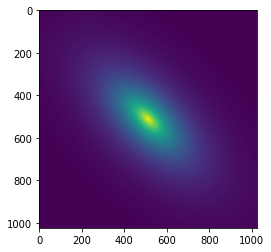

In [13]:
galaxy_image = {}
for b in bands:
    galaxy_image[b]=galaxy.model_image*observed_smooth_flux[b]
plt.imshow(galaxy_image['g'],vmax=galaxy_image['g'].max())

Draw stellar masses stochastically from the IMF.
We need to draw a few extra so that we can make a model of the galaxy where each pixel value is the number of stars drawn from the Poisson probability of the number of stars in that pixel. The sum of these Poisson probabilities might not work out to the exact number of stars corresponding to the `stochastic_fraction` for that total mass.

In [14]:
catalog_extra = 1.1 # Draw about 1.1 times as many stars as we need to allow the model
cluster = imf.make_cluster(stochastic_mass_fraction*galaxy.total_mass*catalog_extra,
                           massfunc='kroupa',mmin=minmass_stochastic)
nstars = len(cluster)/catalog_extra
nstars,len(cluster)

Total cluster mass is 6.57527e+06 (limit was 6.57527e+06)


(1989075.4545454544, 2187983)

In [15]:
galaxy.create_poisson_model(nstars)
galaxy.poisson_model.sum(),len(cluster)

(1989761, 2187983)

For each random stochastic draw of a mass in the cluster, find the nearest mass to it in the isochrone and make an array of these indices into the isochrone array

In [16]:
mass_indices = np.array([(np.abs(isochrone['initial_mass']-m)).argmin() for m in cluster])

Add the stochastic component
 - step through the pixels in the galaxy image and choose N random indices into the array of random masses that we created, where N is the Poisson draw on the stochastic portion of the galaxy model that we created earlier. This gives us the right distribution of masses because that random list of masses was drawn from the mass function. 
 - sum up the fluxes from the stars with the closest masses to these random draws in the isochrone
 - Add that sum to the appropriate pixel in the galaxy image

In [17]:
stochastic_image = {}
for b in bands:
    stochastic_image[b]=galaxy_image[b]*0.
for xx,yy in zip(galaxy.x.flatten(),galaxy.y.flatten()):
    random_indices = np.random.randint(0,len(mass_indices),size=galaxy.poisson_model[xx,yy])
    for b in bands:
        stochastic_image[b][xx,yy] += isochrone[b][mass_indices[random_indices]].sum()

In [18]:
stochastic_image['g'].max(),galaxy_image['g'].max(),galaxy.poisson_model.max()

(1.2932248546087617, 0.06261945068644405, 39)

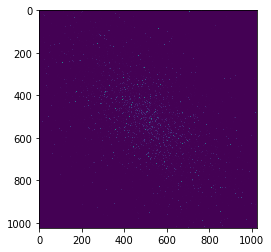

In [19]:
plt.imshow(stochastic_image['g'],vmax=stochastic_image['g'].max())

In [20]:
for b in bands:
    galaxy_image[b] += stochastic_image[b]

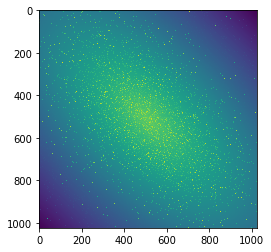

In [21]:
plt.imshow(np.log10(galaxy_image['g']),vmax=np.log10(galaxy_image['g'].max()))

Convolve with the oversampled PSF 
(Should get one for each band)

In [22]:
psf = fits.getdata('/Users/hcferguson/data/dsii_dwarfs/generated_data/moffat_oversampled_psf.fits')

In [23]:
convolved_image = {}
for b in bands:
    convolved_image[b] = convolve_fft(galaxy_image[b],psf)

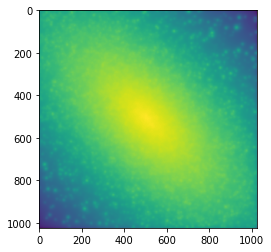

In [24]:
plt.imshow(np.log10(convolved_image['g']),vmax=np.log10(convolved_image['g'].max()))

Downsample by a factor of 4.
The routine below was taken from a scipy cookbook. 

In [25]:
def rebin(a, *args):
    '''rebin ndarray data into a smaller ndarray of the same rank whose dimensions
    are factors of the original dimensions. eg. An array with 6 columns and 4 rows
    can be reduced to have 6,3,2 or 1 columns and 4,2 or 1 rows.
    example usages:
    >>> a=rand(6,4); b=rebin(a,3,2)
    >>> a=rand(6); b=rebin(a,2)
    '''
    shape = a.shape
    lenShape = len(shape)
    factor = (np.asarray(shape)/np.asarray(args)).astype('int64')
    print(np.asarray(shape).dtype,np.asarray(args).dtype,factor.dtype)
    evList = ['a.reshape('] + \
             ['args[%d],factor[%d],'%(i,i) for i in range(lenShape)] + \
             [')'] + ['.sum(%d)'%(i+1) for i in range(lenShape)] \
#             + ['/factor[%d]'%i for i in range(lenShape)]
    print(''.join(evList))
    return eval(''.join(evList))

In [26]:
rebinned_image = {}
nbinnedpix = int(galaxy.npix/4)
for b in bands:
    rebinned_image[b] = rebin(convolved_image[b],nbinnedpix,nbinnedpix)

int64 int64 int64
a.reshape(args[0],factor[0],args[1],factor[1],).sum(1).sum(2)
int64 int64 int64
a.reshape(args[0],factor[0],args[1],factor[1],).sum(1).sum(2)
int64 int64 int64
a.reshape(args[0],factor[0],args[1],factor[1],).sum(1).sum(2)
int64 int64 int64
a.reshape(args[0],factor[0],args[1],factor[1],).sum(1).sum(2)
int64 int64 int64
a.reshape(args[0],factor[0],args[1],factor[1],).sum(1).sum(2)


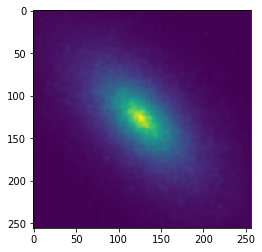

In [27]:
plt.imshow(rebinned_image['g'],vmax=rebinned_image['g'].max())

Check that the absolute magnitude looks reasonable

In [28]:
absmag = {}
for b in bands:
    absmag[b] = -2.5*np.log10(rebinned_image[b].sum())+27.-(5.*np.log10(galaxy.lumdist)+25.)
absmag

{'g': -11.081947191411409,
 'r': -11.605450747614345,
 'i': -11.847467736238247,
 'z': -11.834313812323906,
 'y': -12.023313316040095}